In [24]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Set professional style
plt.style.use('default')
sns.set_palette("husl")

def load_data(data_path, image_size=(32, 32)):
    X, y = [], []
    
    # Get sorted list of class directories
    classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
    if not classes:
        raise ValueError(f"No classes found in directory '{data_path}'.")
    
    # Load images from each class directory
    for label in classes:
        class_dir = os.path.join(data_path, label)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            
            # Skip corrupted or unreadable images
            if img is None:
                print(f"Warning: Can't read image {img_path}, skipping.")
                continue
                
            # Resize image to target size
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(label)
    
    # Convert to numpy array and normalize to [0, 1] range
    X = np.array(X).astype(np.float32) / 255.0
    
    # Apply zero-mean normalization (standardization)
    X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-8)
    
    # Convert labels to numpy array
    y = np.array(y)
    
    # One-hot encode labels
    lb = LabelBinarizer()
    y_encoded = lb.fit_transform(y)
    
    # Flatten images for MLP input
    return X.reshape(len(X), -1), y_encoded, lb, classes


In [28]:
class MLPClassifier:
    """
    Multi-Layer Perceptron classifier with Adam optimizer.
    
    Architecture: Input -> Hidden1 (ReLU) -> Hidden2 (ReLU) -> Output (Softmax)
    """
    
    def __init__(self, input_dim, hidden1, hidden2, output_dim, lr=0.001, reg_lambda=0.001, batch_size=64):
        """
        Initialize MLP with He initialization for weights.
        """
        # Initialize weights using He initialization (optimal for ReLU)
        self.params = {
            'W1': np.random.randn(input_dim, hidden1) * np.sqrt(2. / input_dim),
            'b1': np.zeros((1, hidden1)),
            'W2': np.random.randn(hidden1, hidden2) * np.sqrt(2. / hidden1),
            'b2': np.zeros((1, hidden2)),
            'W3': np.random.randn(hidden2, output_dim) * np.sqrt(2. / hidden2),
            'b3': np.zeros((1, output_dim)),
        }
        
        # Training hyperparameters
        self.lr = lr
        self.initial_lr = lr
        self.reg_lambda = reg_lambda
        self.batch_size = batch_size
        
        # Adam optimizer parameters
        self.adam_params = {}
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0
        
        # Initialize Adam moment estimates
        for key in self.params:
            self.adam_params['m_' + key] = np.zeros_like(self.params[key])
            self.adam_params['v_' + key] = np.zeros_like(self.params[key])

    def relu(self, Z):
        """ReLU activation function: max(0, Z)"""
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        """Derivative of ReLU: 1 if Z > 0, else 0"""
        return (Z > 0).astype(float)

    def softmax(self, Z):
        """Softmax activation function for multi-class classification."""
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        """Forward propagation through the network."""
        W1, b1, W2, b2, W3, b3 = self.params.values()
        
        Z1 = X @ W1 + b1
        A1 = self.relu(Z1)
        
        Z2 = A1 @ W2 + b2
        A2 = self.relu(Z2)
        
        Z3 = A2 @ W3 + b3
        A3 = self.softmax(Z3)
        
        cache = (X, Z1, A1, Z2, A2, Z3, A3)
        return A3, cache

    def compute_loss(self, Y_hat, Y):
        """Compute cross-entropy loss with L2 regularization."""
        m = Y.shape[0]
        
        loss = -np.sum(Y * np.log(Y_hat + 1e-8)) / m
        
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        reg_loss = self.reg_lambda * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2)) / m
        
        return loss + reg_loss

    def adam_update(self, grads):
        """Update parameters using Adam optimizer."""
        self.t += 1
        
        for key in self.params:
            m = self.adam_params['m_' + key]
            v = self.adam_params['v_' + key]
            g = grads[key]
            
            m[:] = self.beta1 * m + (1 - self.beta1) * g
            v[:] = self.beta2 * v + (1 - self.beta2) * (g ** 2)
            
            m_hat = m / (1 - self.beta1 ** self.t)
            v_hat = v / (1 - self.beta2 ** self.t)
            
            self.params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

    def backward(self, cache, Y):
        """Backward propagation to compute gradients."""
        X, Z1, A1, Z2, A2, Z3, A3 = cache
        m = X.shape[0]
        grads = {}

        dZ3 = (A3 - Y) / m
        grads['W3'] = A2.T @ dZ3 + self.reg_lambda * self.params['W3'] / m
        grads['b3'] = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = dZ3 @ self.params['W3'].T
        dZ2 = dA2 * self.relu_derivative(Z2)
        grads['W2'] = A1.T @ dZ2 + self.reg_lambda * self.params['W2'] / m
        grads['b2'] = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.params['W2'].T
        dZ1 = dA1 * self.relu_derivative(Z1)
        grads['W1'] = X.T @ dZ1 + self.reg_lambda * self.params['W1'] / m
        grads['b1'] = np.sum(dZ1, axis=0, keepdims=True)

        self.adam_update(grads)

    def predict(self, X):
        """Make predictions for input data."""
        Y_hat, _ = self.forward(X)
        return np.argmax(Y_hat, axis=1)

    def visualize_sample_predictions(self, X_batch, Y_batch, lb, title, n_samples=8):
        """Visualize sample predictions before or after training."""
        Y_pred_probs, _ = self.forward(X_batch)
        Y_pred = np.argmax(Y_pred_probs, axis=1)
        Y_true = np.argmax(Y_batch, axis=1)

        fig, axes = plt.subplots(2, n_samples//2, figsize=(16, 8))
        fig.suptitle(title, fontsize=16, fontweight='bold')
        
        for i in range(n_samples):
            row = i // (n_samples//2)
            col = i % (n_samples//2)
            
            # Reshape and denormalize image
            img = X_batch[i].reshape(32, 32, 3)
            img_std = np.std(X_batch, axis=0).reshape(32, 32, 3)
            img_mean = np.mean(X_batch, axis=0).reshape(32, 32, 3)
            img = (img * img_std) + img_mean
            img = np.clip(img, 0, 1)
            
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            
            # Prediction details
            true_class = lb.classes_[Y_true[i]]
            pred_class = lb.classes_[Y_pred[i]]
            confidence = Y_pred_probs[i, Y_pred[i]] * 100
            is_correct = Y_pred[i] == Y_true[i]
            
            # Color coding
            color = 'green' if is_correct else 'red'
            status = "✓" if is_correct else "✗"
            
            title_text = f"{status} True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)"
            axes[row, col].set_title(title_text, fontsize=10, color=color, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    def plot_training_curves(self, train_losses, train_accuracies, val_losses, val_accuracies):
        """Plot training and validation curves."""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('Training Progress', fontsize=16, fontweight='bold')
        
        epochs = range(1, len(train_losses) + 1)
        
        # Loss curves
        axes[0].plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
        if val_losses:
            axes[0].plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss Curves')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy curves
        axes[1].plot(epochs, [acc*100 for acc in train_accuracies], 'b-', 
                    label='Training Accuracy', linewidth=2)
        if val_accuracies:
            axes[1].plot(epochs, [acc*100 for acc in val_accuracies], 'r-', 
                        label='Validation Accuracy', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].set_title('Accuracy Curves')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim(0, 100)

        plt.tight_layout()
        plt.show()

    def fit(self, X, Y, X_val=None, Y_val=None, epochs=100, lb=None):
        """Train the MLP using mini-batch gradient descent with Adam optimizer."""
        n_samples = X.shape[0]
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []

        print("=== Training Setup ===")
        print(f"Training samples: {n_samples}")
        print(f"Input dimension: {X.shape[1]}")
        print(f"Number of classes: {Y.shape[1]}")
        print(f"Batch size: {self.batch_size}")
        print(f"Initial learning rate: {self.lr}")
        
        # Show initial predictions
        if lb is not None:
            sample_indices = np.random.choice(len(X), 8, replace=False)
            self.visualize_sample_predictions(X[sample_indices], Y[sample_indices], lb, 
                                            "Initial Predictions (Before Training)")

        print("\n=== Starting Training ===")
        
        for epoch in range(epochs):
            # Learning rate decay every 20 epochs
            if epoch > 0 and epoch % 20 == 0:
                self.lr *= 0.7
                print(f"Learning rate decayed to {self.lr:.6f}")

            # Shuffle data for each epoch
            permutation = np.random.permutation(n_samples)
            X_shuffled = X[permutation]
            Y_shuffled = Y[permutation]

            batch_losses = []

            # Mini-batch training
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                Y_batch = Y_shuffled[i:i+self.batch_size]
                
                Y_hat, cache = self.forward(X_batch)
                batch_loss = self.compute_loss(Y_hat, Y_batch)
                batch_losses.append(batch_loss)
                self.backward(cache, Y_batch)

            # Compute full training set metrics
            Y_hat_full, _ = self.forward(X)
            loss = self.compute_loss(Y_hat_full, Y)
            acc = np.mean(np.argmax(Y_hat_full, axis=1) == np.argmax(Y, axis=1))

            train_losses.append(loss)
            train_accuracies.append(acc)

            # Validation metrics if validation set provided
            if X_val is not None and Y_val is not None:
                Y_val_hat, _ = self.forward(X_val)
                val_loss = self.compute_loss(Y_val_hat, Y_val)
                val_acc = np.mean(np.argmax(Y_val_hat, axis=1) == np.argmax(Y_val, axis=1))
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

            # Progress reporting every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"  Train Loss: {loss:.4f}, Train Acc: {acc*100:.2f}%")
                if X_val is not None and Y_val is not None:
                    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        # Show final predictions
        if lb is not None:
            if X_val is not None:
                sample_indices = np.random.choice(len(X_val), 8, replace=False)
                self.visualize_sample_predictions(X_val[sample_indices], Y_val[sample_indices], lb, 
                                                "Final Predictions (After Training)")
            else:
                sample_indices = np.random.choice(len(X), 8, replace=False)
                self.visualize_sample_predictions(X[sample_indices], Y[sample_indices], lb, 
                                                "Final Predictions (After Training)")

        # Plot training curves
        self.plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)
        
        return train_losses, train_accuracies, val_losses, val_accuracies

    def evaluate(self, X_test, Y_test, classes):
        """Evaluate model performance on test set."""
        Y_pred = self.predict(X_test)
        Y_true = np.argmax(Y_test, axis=1)
        accuracy = np.mean(Y_pred == Y_true)
        
        print("\n=== Model Evaluation ===")
        print(f"Test Accuracy: {accuracy*100:.2f}%")
        print("\nClassification Report:")
        print(classification_report(Y_true, Y_pred, target_names=classes))
        
        # Confusion Matrix
        cm = confusion_matrix(Y_true, Y_pred)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        return {
            'accuracy': accuracy,
            'predictions': Y_pred,
            'true_labels': Y_true,
            'classification_report': classification_report(Y_true, Y_pred, target_names=classes, output_dict=True)
        }

Loading data...
Loaded 25740 samples
Image dimensions: 3072 (flattened from 32x32x3)
Number of classes: 33
Classes: ya, yab, yach, yad, yadd, yae, yaf, yag, yagh, yagw, yah, yahh, yaj, yak, yakw, yal, yam, yan, yaq, yar, yarr, yas, yass, yat, yatt, yaw, yax, yay, yaz, yazz, yey, yi, yu
Training samples: 20592
Validation samples: 5148

Model Architecture:
Input Layer: 3072 neurons
Hidden Layer 1: 64 neurons (ReLU)
Hidden Layer 2: 32 neurons (ReLU)
Output Layer: 33 neurons (Softmax)
Total parameters: 199841
=== Training Setup ===
Training samples: 20592
Input dimension: 3072
Number of classes: 33
Batch size: 64
Initial learning rate: 0.001


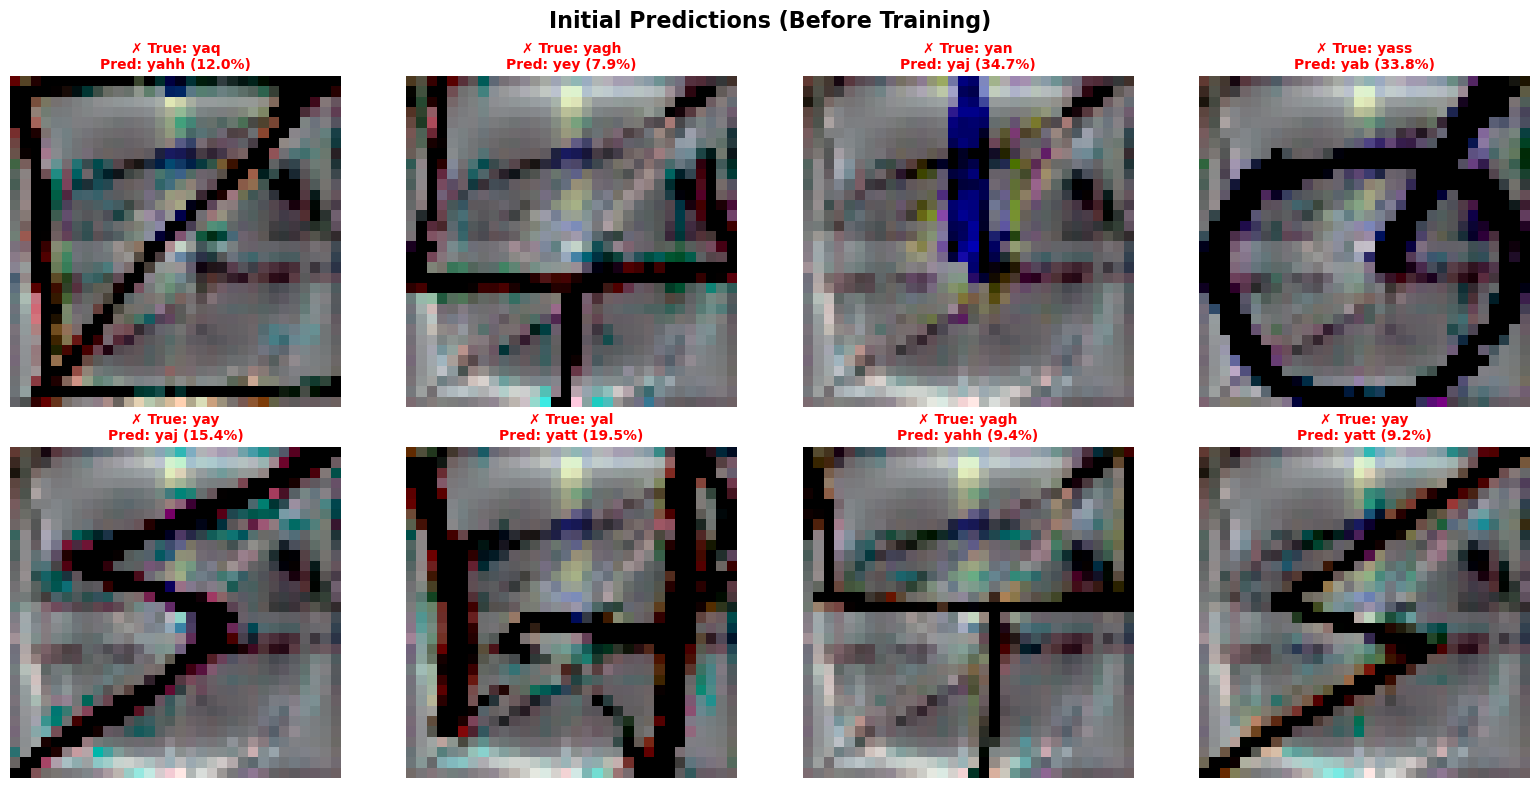


=== Starting Training ===
Epoch 10/100
  Train Loss: 0.0380, Train Acc: 98.99%
  Val Loss: 0.4200, Val Acc: 92.56%
Epoch 20/100
  Train Loss: 0.0103, Train Acc: 99.70%
  Val Loss: 0.4557, Val Acc: 93.75%
Learning rate decayed to 0.000700
Epoch 30/100
  Train Loss: 0.0005, Train Acc: 100.00%
  Val Loss: 0.3942, Val Acc: 94.58%
Epoch 40/100
  Train Loss: 0.0004, Train Acc: 100.00%
  Val Loss: 0.4274, Val Acc: 94.70%
Learning rate decayed to 0.000490
Epoch 50/100
  Train Loss: 0.0003, Train Acc: 100.00%
  Val Loss: 0.4123, Val Acc: 94.79%
Epoch 60/100
  Train Loss: 0.0004, Train Acc: 100.00%
  Val Loss: 0.4386, Val Acc: 94.33%
Learning rate decayed to 0.000343
Epoch 70/100
  Train Loss: 0.0006, Train Acc: 99.99%
  Val Loss: 0.4218, Val Acc: 94.21%
Epoch 80/100
  Train Loss: 0.0002, Train Acc: 100.00%
  Val Loss: 0.3945, Val Acc: 94.60%
Learning rate decayed to 0.000240
Epoch 90/100
  Train Loss: 0.0002, Train Acc: 100.00%
  Val Loss: 0.3282, Val Acc: 94.97%
Epoch 100/100
  Train Loss: 0.

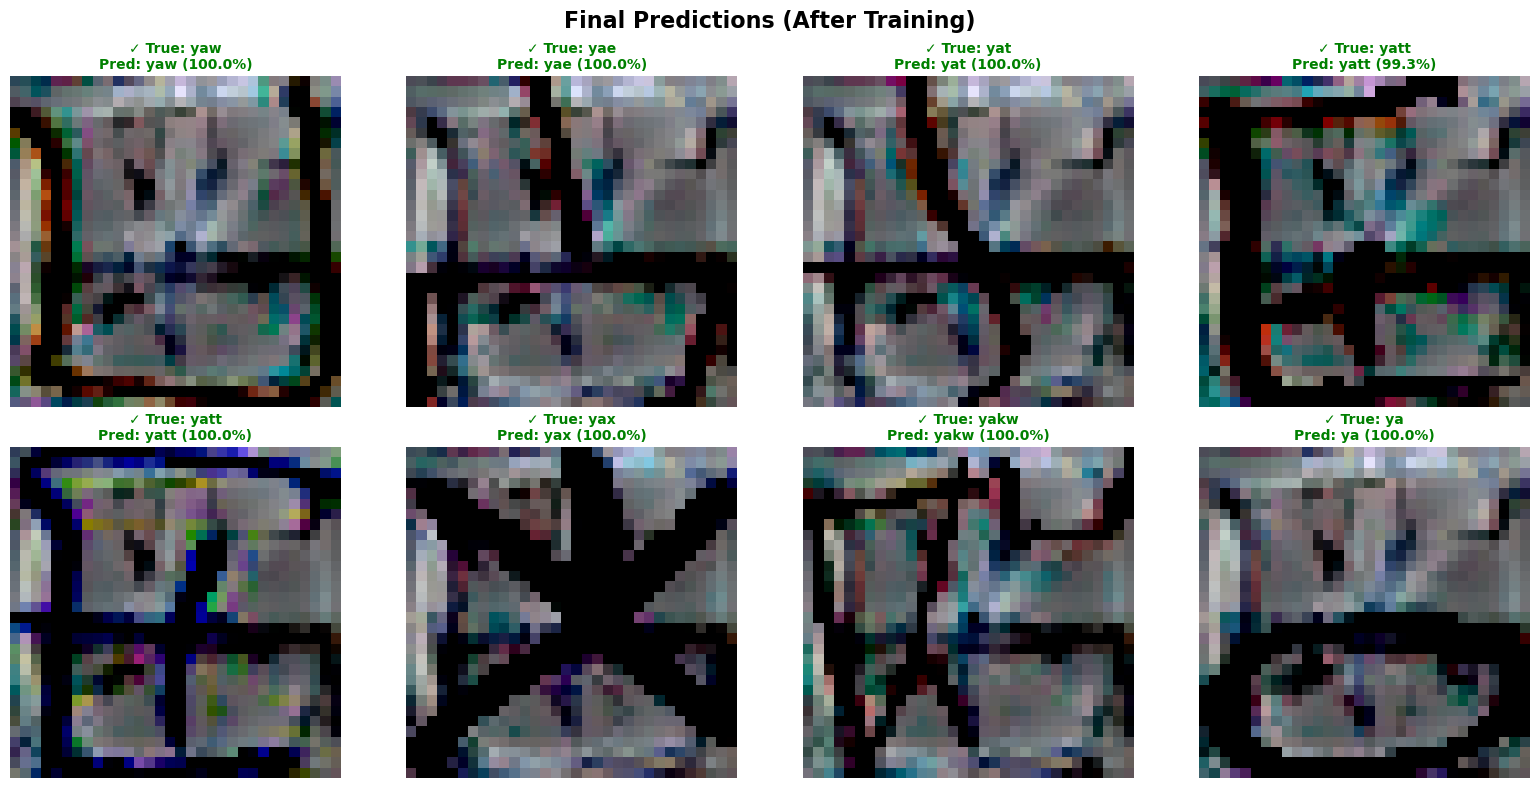

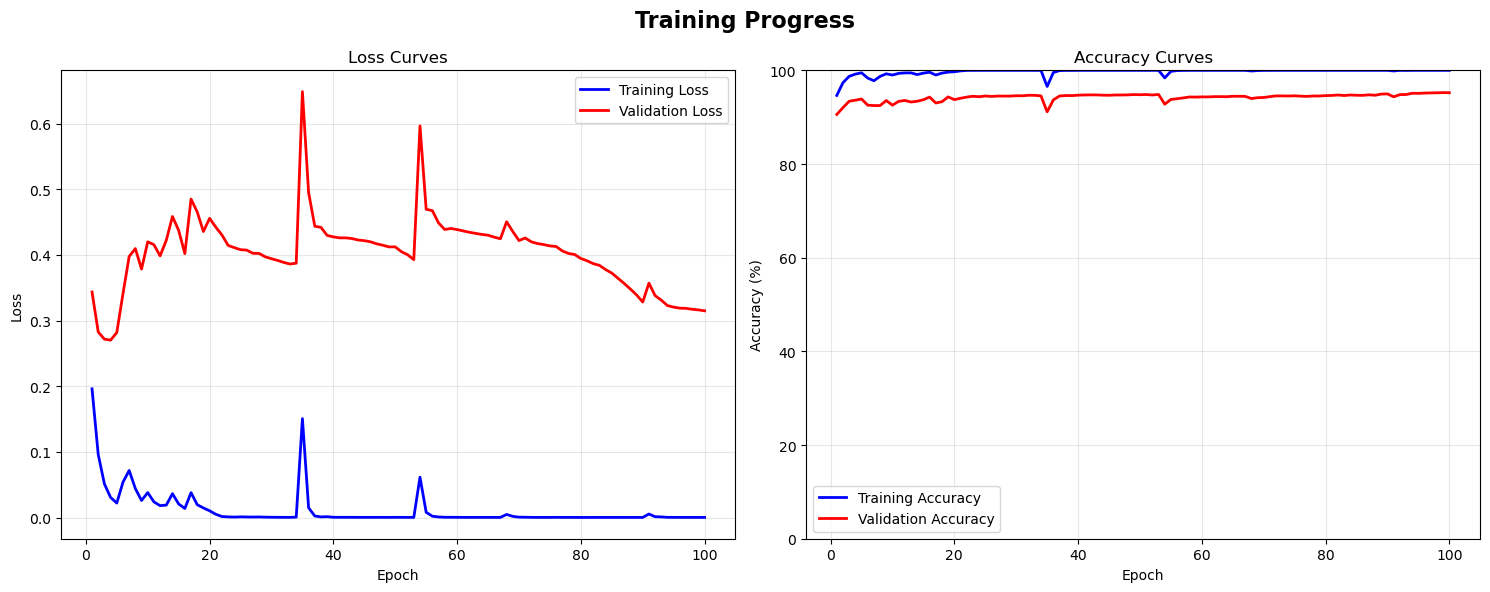


=== Model Evaluation ===
Test Accuracy: 95.22%

Classification Report:
              precision    recall  f1-score   support

          ya       0.99      0.99      0.99       156
         yab       0.99      0.98      0.99       156
        yach       0.97      0.97      0.97       156
         yad       0.95      0.97      0.96       156
        yadd       0.94      0.94      0.94       156
         yae       0.99      0.99      0.99       156
         yaf       0.98      0.94      0.96       156
         yag       0.97      0.96      0.96       156
        yagh       0.96      0.96      0.96       156
        yagw       0.93      0.96      0.94       156
         yah       0.97      0.99      0.98       156
        yahh       0.94      0.97      0.96       156
         yaj       0.99      0.98      0.98       156
         yak       0.93      0.91      0.92       156
        yakw       0.94      0.97      0.96       156
         yal       0.93      0.92      0.93       156
         

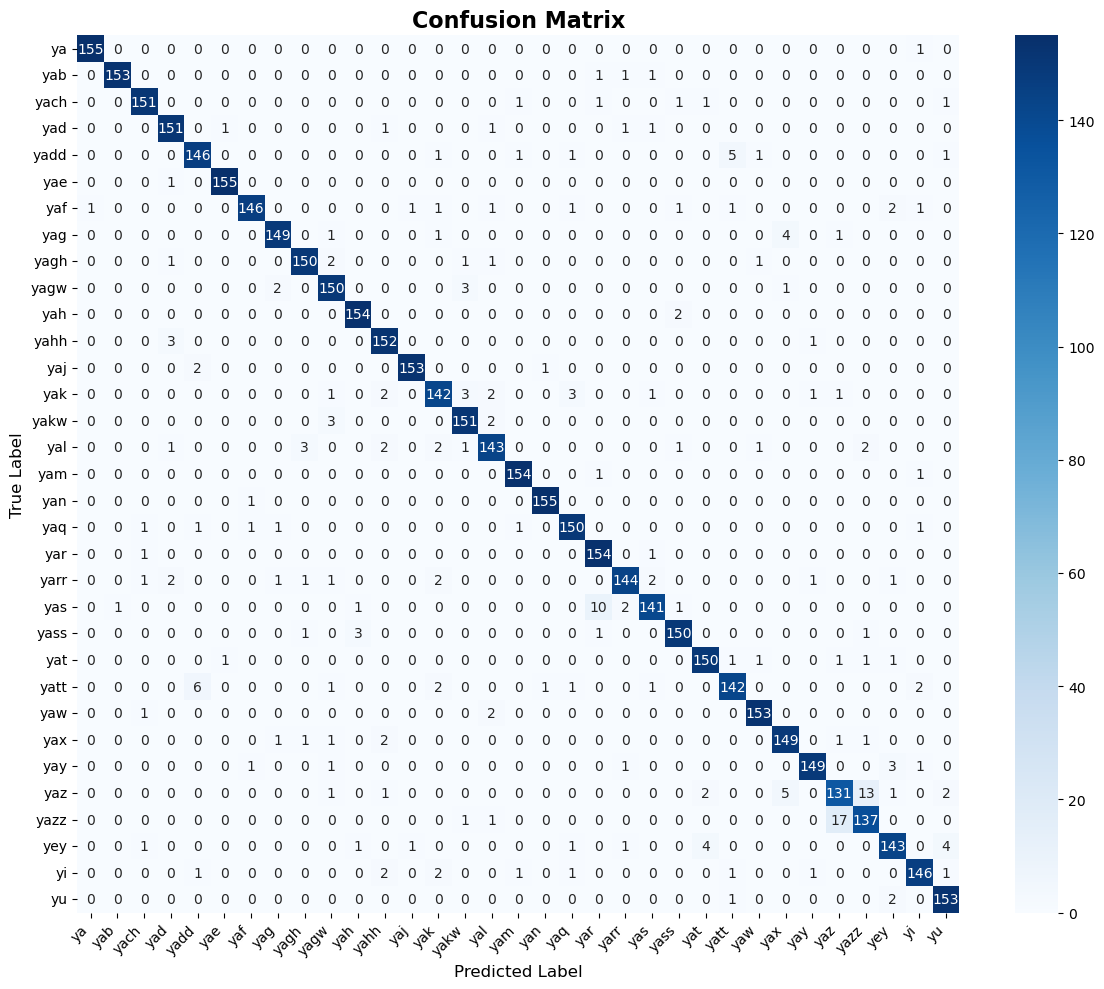


=== Final Results ===
Final Training Loss: 0.0002
Final Training Accuracy: 100.00%
Final Validation Loss: 0.3148
Final Validation Accuracy: 95.22%
Best Validation Accuracy: 95.24% (Epoch 99)


In [30]:
# Load and preprocess data
print("Loading data...")
X, Y, lb, classes = load_data('./dataset/AMHCD_64/AMHCD_64')

print(f"Loaded {X.shape[0]} samples")
print(f"Image dimensions: {X.shape[1]} (flattened from 32x32x3)")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {', '.join(classes)}")

# Split data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

# Initialize model
input_dim = X.shape[1]
hidden1 = 64
hidden2 = 32
output_dim = len(classes)

model = MLPClassifier(
    input_dim=input_dim,
    hidden1=hidden1,
    hidden2=hidden2,
    output_dim=output_dim,
    lr=0.001,
    reg_lambda=0.001,
    batch_size=64
)

print(f"\nModel Architecture:")
print(f"Input Layer: {input_dim} neurons")
print(f"Hidden Layer 1: {hidden1} neurons (ReLU)")
print(f"Hidden Layer 2: {hidden2} neurons (ReLU)")
print(f"Output Layer: {output_dim} neurons (Softmax)")
print(f"Total parameters: {sum(p.size for p in model.params.values())}")

# Train model
train_losses, train_accuracies, val_losses, val_accuracies = model.fit(
    X_train, Y_train, X_val, Y_val, epochs=100, lb=lb
)

# Evaluate on validation set
eval_results = model.evaluate(X_val, Y_val, classes)

# Training summary
print(f"\n=== Final Results ===")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]*100:.2f}%")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%")
print(f"Best Validation Accuracy: {max(val_accuracies)*100:.2f}% (Epoch {np.argmax(val_accuracies)+1})")